In [1]:
# Decomposing track into large-scale & small-scale track by
# 1. Making moving-average (MA) tracks which looks like it's the center line
#   ('spine') of the meanders while still being relatively straight
# 2. Subtracting the angles of the MA track from the original track, giving 'unwound' track
# 3. Repeating for different smoothing window-sizes
# ToDo: When the unwound track is locally not oscillating around the spine, smooth the unwound track again.
#       Find [wave length, amplitude, variance of both] of the unwound track
#       Use above descriptors for principled RWM; Use wave length for eigenAnts, etc.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%run ../data_prep/trackfuns
# import trackfuns as tf
from scipy.signal import find_peaks
# Clustering
# from scipy import sparse # For clustering
# import dtw # For DTW analysis, pip install dtw-python from https://dynamictimewarping.github.io/python/
# from sklearn.cluster import SpectralClustering as specClust

In [2]:
# Get data
newData = 1 # 0 if continuing from movAv & unwindAnt, 1 if starting from new raw track
inDatFolder = r'C:\Users\stpop\Documents\MATLAB\clean_652660_unw'
rawFileName = '\HRM_T1_ants'
varNames = ['x','y','t','id']
inDat = addMetrics(pd.read_csv(inDatFolder+rawFileName+'.txt', usecols=varNames))
ids = np.unique(inDat.id)

In [3]:
# Either make movAv & unwind or load those data in
if newData == 1:
    movAv,maMatch = movAvMaker(inDat[inDat.id==54])
    unwound = unwinder(inDat[inDat.id==54], maMatch)
    # Save to file
    movAv.to_csv(inDatFolder+rawFileName+'movAv.txt')
    maMatch.to_csv(inDatFolder+rawFileName+'maMatch.txt')
    unwound.to_csv(inDatFolder+rawFileName+'unwound.txt')
    
else: # Load already made movAv & unwound data
    movAv = pd.read_csv(inDatFolder+rawFileName+'movAv.txt')
    maMatch = pd.read_csv(inDatFolder+rawFileName+'maMatch.txt')
    unwound = pd.read_csv(inDatFolder+rawFileName+'unwound.txt')

C:\Users\stpop\Documents\GitHub\model_ant_trajectories\data_prep\trackfuns.py:182: RuntimeWarning: invalid value encountered in remainder
  dTheta = (inDat.theta.values - maMatch.theta.values + 180) % (360) - 180 # difference between raw heading & movAv heading
C:\Users\stpop\Documents\GitHub\model_ant_trajectories\data_prep\trackfuns.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maMatch['d'] = d[d != 0]
C:\Users\stpop\Documents\GitHub\model_ant_trajectories\data_prep\trackfuns.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [4]:
# Select current track for spot analysis
id=46 # index 46 of ids list (id=54)
currRaw = inDat.loc[inDat.id==ids[id]]
currMovAv = movAv[movAv.id==ids[id]]
currMaMatch = maMatch[maMatch.id==ids[id]]
currUnwound = unwound[unwound.id==ids[id]]

<IPython.core.display.Javascript object>


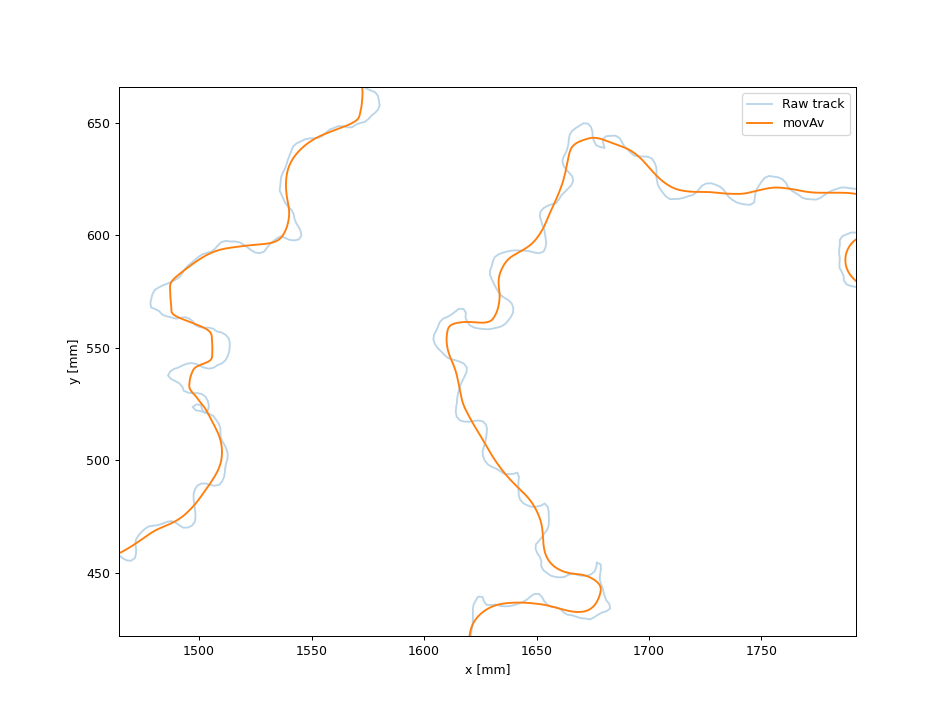

In [24]:
# Plot track & movAv
%matplotlib inline
%matplotlib notebook
plt.plot(currRaw.x,currRaw.y, alpha=0.3, label='Raw track')
plt.plot(currMovAv.x,currMovAv.y, label='movAv')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.legend()
plt.axis('equal')
plt.show()
#id += 1

<IPython.core.display.Javascript object>


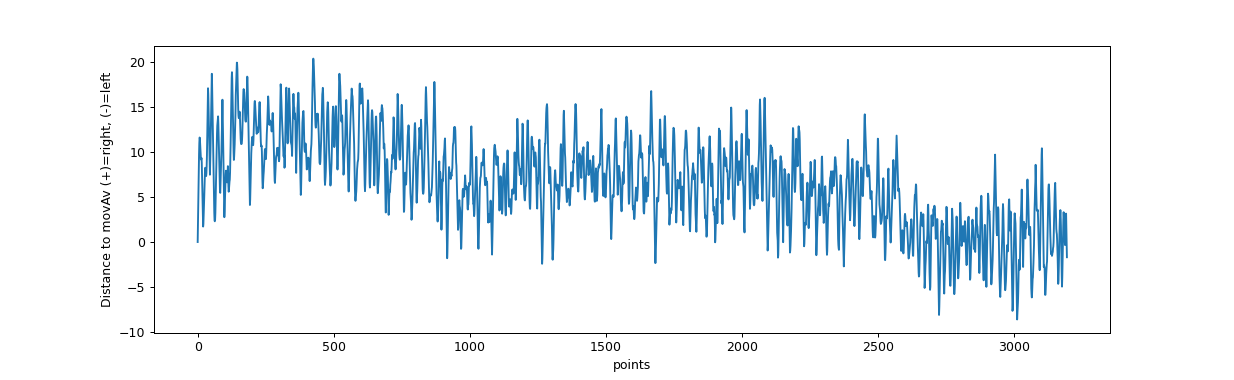

Text(0, 0.5, 'Distance to movAv (+)=right, (-)=left')

In [27]:
# Plot unwound track
%matplotlib inline
%matplotlib notebook
plt.plot(currUnwound.y)
plt.xlabel('points')
plt.ylabel('Distance to movAv (+)=right, (-)=left')

<IPython.core.display.Javascript object>


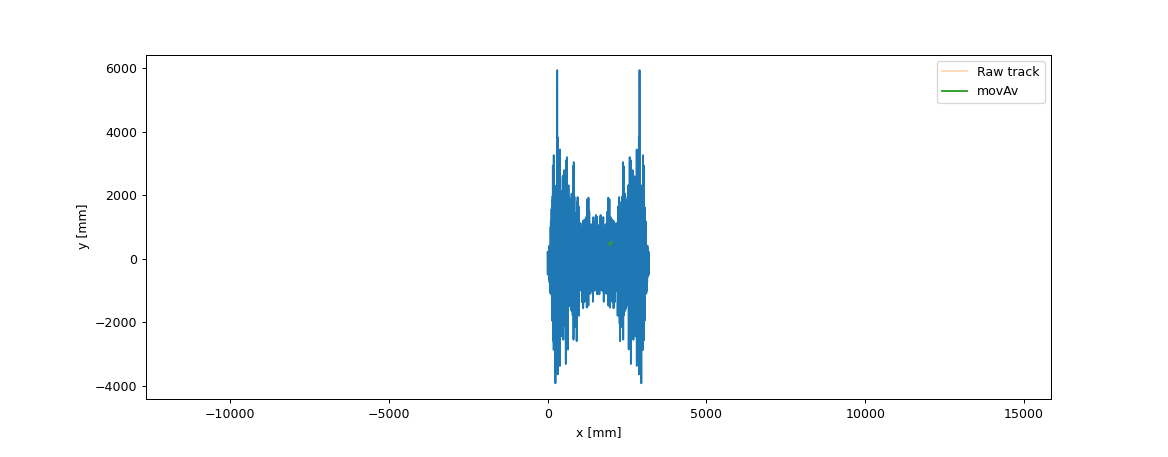

C:\Users\stpop\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [19]:
# FFT??
%matplotlib inline
%matplotlib notebook
sp = np.fft.fft(currUnwound.alpha[1:-2])
# sp = np.fft.fftfreq(currUnwound.alpha[1:-2])
plt.plot(sp)

In [18]:
currUnwound

,x,y,t,id,theta,alpha
0,0.000000,0.000000,1800.040,54.0,NaN,NaN
1,0.083763,2.012976,1800.316,54.0,87.667925,2.157950
2,0.091796,4.059862,1800.556,54.0,89.825875,18.218200
3,-0.541199,6.008789,1800.831,54.0,108.044076,-26.136490
4,-0.251887,8.030682,1801.067,54.0,81.907585,-26.581627
...,...,...,...,...,...,...
3191,5372.009626,3.030388,2619.511,54.0,68.082293,-64.394913
3192,5374.033361,3.159010,2619.858,54.0,3.687380,-48.314918
3193,5375.488046,1.720570,2620.098,54.0,-44.627538,-11.689752
3194,5376.632576,0.000000,2620.293,54.0,-56.317291,2.098695


### Feature (= turn) extraction using distance to moving average track

In [628]:
# Pick local extrema of unwound (d)
#     decide how to deal with small loops in original track: cutting up?
# Potential cut points of turns: dMax, or sometime around dMin
# Get characteristics from each turn (see below)
# Crossing points with movAv are potential cut points of turns (when movAv actually goes through track)

<IPython.core.display.Javascript object>


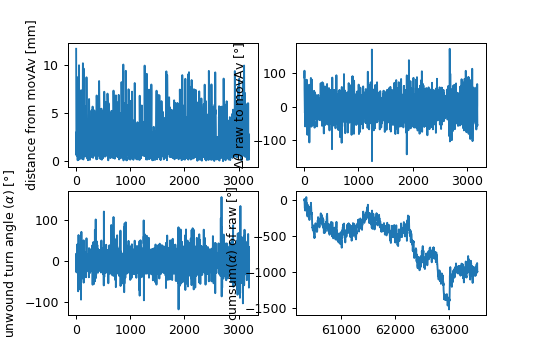

In [28]:
# Plot metrics of tracks: d, alpha, dTheta
fig,axs = plt.subplots(2,2)
axs[0,0].plot(currMaMatch.d)
axs[0,0].set(ylabel='distance from movAv [mm]')
axs[0,1].plot(currMaMatch.dTheta)
axs[0,1].set(ylabel=r'$\Delta$$\theta$ raw to movAv [°]')
axs[1,0].plot(currUnwound.alpha)
axs[1,0].set(ylabel='unwound turn angle ('+r'$\alpha$) [°]')
axs[1,1].plot(np.cumsum(currRaw.alpha))
axs[1,1].set(ylabel='cumsum('+r'$\alpha$) of raw [°]')
plt.show()

In [20]:
# Make local peaks
dIdx, maxdPeakProp = find_peaks(currMaMatch.d, prominence=2.5) # green: d: Where raw track is farthest away from movAv
maxAlphaIdx, _ = find_peaks(currUnwound.alpha, prominence=30, distance=5)
minAlphaIdx, _ = find_peaks(-currUnwound.alpha, prominence=30, distance=5)
alphaIdx = np.sort(np.concatenate((maxAlphaIdx,minAlphaIdx))) # orange: turn angle in unwound
maxdThetaIdx, maxdThetaPeakProp = find_peaks(currMaMatch.dTheta, prominence=30)
mindThetaIdx, mindThetaPeakProp = find_peaks(-currMaMatch.dTheta, prominence=30)
dThetaIdx = np.sort(np.concatenate((maxdThetaIdx,mindThetaIdx))) # blue: heading angle diff between raw & mov av

<IPython.core.display.Javascript object>


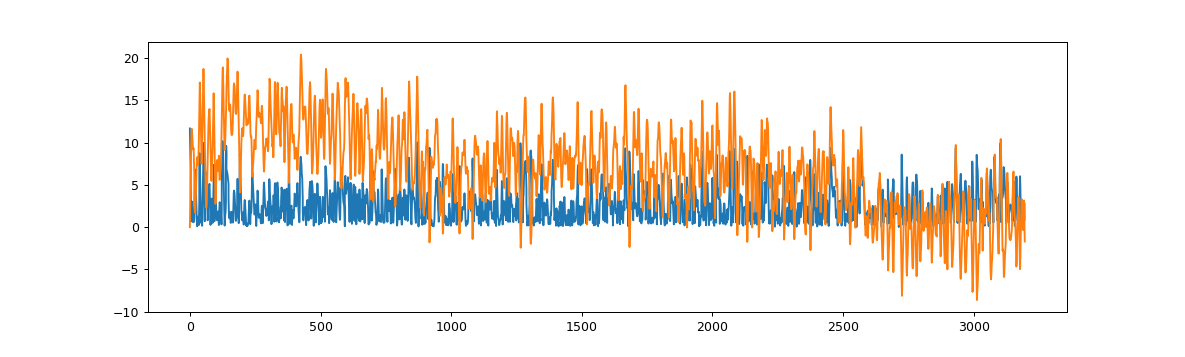

NameError: name 'd' is not defined

In [75]:
# Plot metrics with peaks
%matplotlib inline
%matplotlib notebook
# d
plt.plot(currMaMatch.d)
plt.plot(dIdx,currMaMatch[dIdx],'x',markersize=2)
# alpha
plt.plot(currUnwound.alpha)
plt.plot(currUnwound.alpha[alphaIdx],'x',markersize=2)
# dTheta
plt.plot(currMaMatch.dTheta)
plt.plot(currMaMatch[dThetaIdx],'x',markersize=2)
plt.show()

<IPython.core.display.Javascript object>


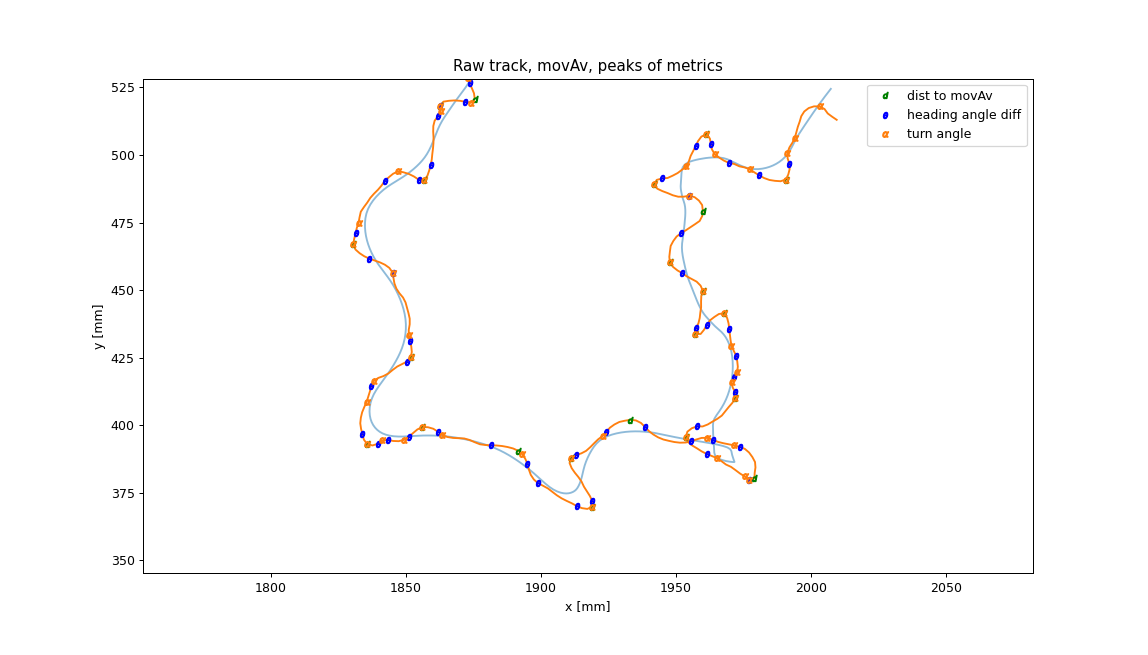

In [21]:
# Plot track with peaks
%matplotlib inline
%matplotlib notebook
plt.plot(currMovAv.x,currMovAv.y,alpha=0.5)
plt.plot(currRaw.x,currRaw.y)
plt.plot(currRaw.x.iloc[dIdx],     currRaw.y.iloc[dIdx],linestyle='None', marker='$d$',markersize=5,c='g',label='dist to movAv')
plt.plot(currRaw.x.iloc[dThetaIdx],currRaw.y.iloc[dThetaIdx],linestyle='None',marker=r'$\theta$',markersize=5,c='b',label='heading angle diff')
plt.plot(currRaw.x.iloc[alphaIdx], currRaw.y.iloc[alphaIdx],linestyle='None',marker=r'$\alpha$',markersize=5,c='tab:orange',label='turn angle')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Raw track, movAv, peaks of metrics')
plt.legend()

plt.axis('equal')
plt.show()

In [50]:
# Turn Characteristics
cutMetric = 'd'
if cutMetric == 'alpha': # Cut by alpha
    # Assign points to turns, via turnNr column
    cRaw = currRaw.reset_index()
    turnLength = np.diff(np.hstack([0,alphaIdx,len(cRaw)]))
    nrOfTurns = len(alphaIdx)+1
    cRaw['turn'] = np.array(range(0,nrOfTurns)).repeat(turnLength)

    # Flipping net left-turns to be net-right turns
    l = cRaw.groupby(['turn']).alpha.sum()<0
    lIdx = l.repeat(turnLength).reset_index()
    cRaw['alphaAbs'] = cRaw.alpha
    cRaw.alphaAbs[lIdx.alpha==True] = -cRaw.alphaAbs[lIdx.alpha==True]
    cRaw['yAbs'] = cRaw.y
    cRaw.yAbs[lIdx.alpha==True] = -cRaw.yAbs[lIdx.alpha==True]
    
elif cutMetric == 'd': # Cut by d
    cRaw = currRaw.reset_index()
    turnLength = np.diff(np.hstack([0,dIdx,len(cRaw)]))
    nrOfTurns = len(dIdx)+1
    cRaw['turn'] = np.array(range(0,nrOfTurns)).repeat(turnLength)

In [ ]:
ax = plt.axes(projection='3d')
# ax.plot3D(d,range(0,len(d)),np.abs(dTheta),alpha=0.8)
ax.scatter3D(d,np.abs(dTheta),np.abs(currRaw.alpha))
ax.set(xlabel='d',ylabel='abs dtheta',zlabel='abs alpha')

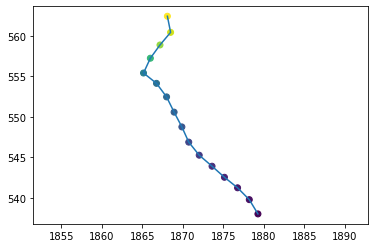

In [73]:
# Plot example turns
%matplotlib inline
# i = 1
plt.plot(cRaw.x[cRaw.turn==i],cRaw.y[cRaw.turn==i])
plt.scatter(cRaw.x[cRaw.turn==i],cRaw.y[cRaw.turn==i], c=cRaw.t[cRaw.turn==i])
plt.axis('equal')
i += 1

<IPython.core.display.Javascript object>


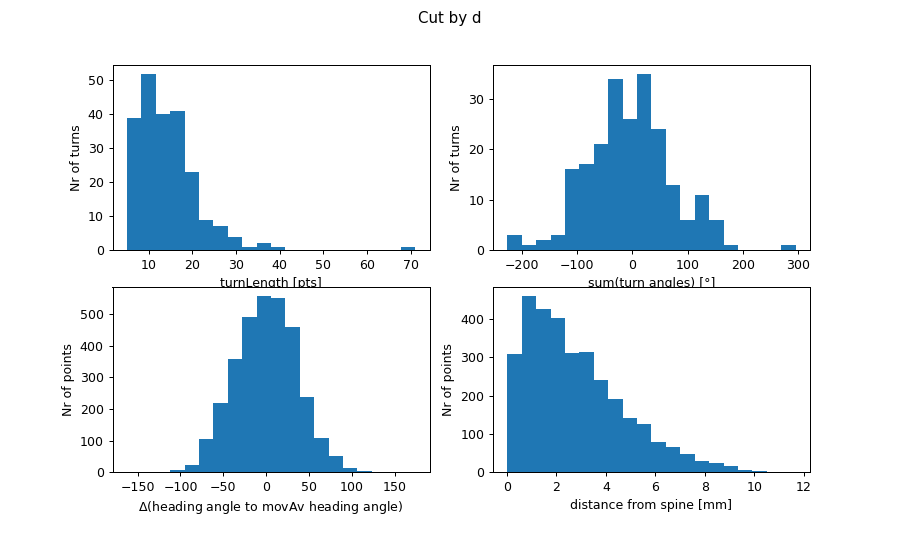

In [106]:
# Characteristics of turns (for Random Walk Model): Histograms
fig,axs = plt.subplots(2,2,figsize=(10,6))
fig.suptitle('Cut by '+cutMetric)
# T (turn length = wavelength)
axs[0,0].hist(turnLength,20)
axs[0,0].set(xlabel="turnLength [pts]",ylabel="Nr of turns")

# sum(alpha) = end - start orientation (absolute values: l & r treated the same)
aSum = cRaw.groupby(['turn']).alpha.sum()
# aSum = cRaw.groupby(['turn']).alphaAbs.sum()
axs[0,1].hist(aSum,20)
axs[0,1].set(xlabel="sum(turn angles) [°]",ylabel="Nr of turns")

# Points
# d (distance from movAv)
axs[1,1].hist(currMaMatch.d,20)
axs[1,1].set(xlabel="distance from spine [mm]",ylabel="Nr of points")
# dTheta
axs[1,0].hist(currMaMatch.dTheta,20)
axs[1,0].set(xlabel=r"$\Delta$(heading angle to movAv heading angle)",ylabel="Nr of points")

plt.show()

In [ ]:
# ### ### ### OPTIONAL (and currently not working) ### ### ###
# W/in track distributions (spaghetti of raw turns, add as second row to the above)
# scale, bring to same orientation, something else?
for tur in range(0,nrOfTurns):
    plt.plot(cRaw.alpha[cRaw.turn==tur])

# theta vs movAv theta
for tur in range(0,nrOfTurns):
    thetaRel = currUnw.theta - cRaw.theta # former doesn't exist yet

## Clustering
For now, we keep turns of variable length, then apply DTW as distance measure to get affinity/similarity matrix, which we then feed into a cluster algorithm which can take precomputed matrices as input.
Problem: DTW does not give us directionality of distances at each point of the vector, so left-skewed and right-skewed turns get the same distance (but are behaviorally distinct). Ideally, we'd get either 1) a multi-dimensional distance metric, or 2) employ another feature-extraction method for time-series with variable feature lengths.

In [ ]:
# Load in data from scale decomposition or


### DTW distances

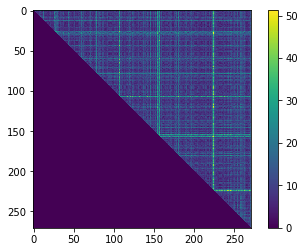

395375.0003256645

In [850]:
# DO THIS ON ALL RIGHT TURNS [or should I?]
dtwDist = np.zeros((nrOfTurns,nrOfTurns))
for tur1 in range(0,nrOfTurns-1):
    for tur2 in range(tur1+1,nrOfTurns):
        dtwCurr = dtw.dtw(cRaw.alphaAbs[cRaw.turn==tur1][1:],cRaw.alphaAbs[cRaw.turn==tur2][1:]) # [1:] to omit NaNs
        dtwDist[tur1,tur2] = dtwCurr.normalizedDistance
dtwDistSprs = sparse.csr_matrix(dtwDist)
# Plotting
plt.imshow(dtwDist, interpolation='none')
plt.colorbar()
plt.show()
np.sum(dtwDistSprs)

### Spectral Clustering
Low-dimensional embedding → K-means (or the like).

In [844]:
k = 8
sc = specClust(n_clusters=k, affinity='precomputed', assign_labels='discretize')
specClustLabels = sc.fit_predict(dtwDistSprs) 
cRaw['turnCluster'] = np.array(specClustLabels).repeat(turnLength)

C:\Users\stpop\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


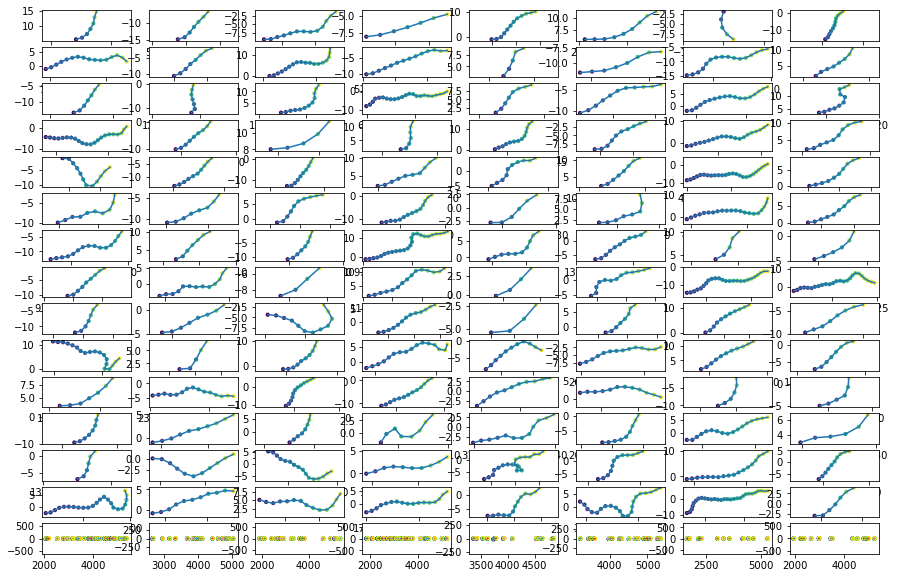

In [845]:
# Plot turns individually [first, find max #of turns in a cluster]
i = np.zeros(k, dtype=int)
nrTileRows = 15
fig,axs = plt.subplots(nrTileRows,k,figsize=(15,10))
for tur in range(0,nrOfTurns):
    j = np.max(cRaw.turnCluster[cRaw.turn==tur])
    axs[i[j],j].plot(cRaw.x[cRaw.turn==tur],cRaw.yAbs[cRaw.turn==tur],)
    axs[i[j],j].scatter(cRaw.x[cRaw.turn==tur],cRaw.yAbs[cRaw.turn==tur],c=cRaw.t[cRaw.turn==tur],s=10)
    axs[i[j],j].axis('equal')
    if i[j]<nrTileRows-1:
        i[j] += int(1)
    if np.all(i)>nrTileRows-1:
        break

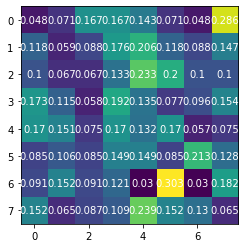

In [738]:
# Build transition matrix from clusters
clustSeq = cRaw.groupby(['turn']).turnCluster.mean() # Which cluster is followed by which other cluster
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states
    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

transMat = np.array(transition_matrix(clustSeq.astype(int)))

# Plot transition matrix
#plt.imshow(transMat,interpolation='none')
#plt.colorbar()
#plt.show()
#for (j,i),label in np.ndenumerate(transMat):
#    plt.text(i,j,label,ha='center',va='center')
fig, ax = plt.subplots()
im = ax.imshow(transMat)   
for i in range(len(transMat)):
    for j in range(len(transMat)):
        text = ax.text(j, i, round(transMat[i, j],3),
                       ha="center", va="center", color="w")
        

### DBSCAN (allows excluding outliers)
Picks dense areas in sample space, creates dendrograms & cuts branches based on epsilon input. Singletons (=outliers) possible.

In [ ]:
from sklearn.cluster import DBSCAN

In [524]:
epsilon = 3.8
dc = DBSCAN(eps=epsilon, min_samples=11, metric='precomputed')
dbClustLabels = dc.fit_predict(dtwDistSprs) 
cRaw['turnDBCluster'] = np.array(dbClustLabels).repeat(turnLength)

C:\Users\stpop\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:175: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


In [525]:
# Count how many turns are in each cluster
dbClusts = np.unique(cRaw.turnDBCluster) # Nr of clusters DBSCAN identified
i = 0
nrTurnsPerClust = np.zeros((len(dbClusts),2))
for c in dbClusts:
    nrTurnsPerClust[i,0] = c
    nrTurnsPerClust[i,1] = len(np.unique(cRaw.turn[cRaw.turnDBCluster==c]))
    i+=1
maxNrTurnsPerCluster = np.max(nrTurnsPerClust) # Used for plotting ALL turns
len(dbClusts), maxNrTurnsPerCluster

(4, 190.0)

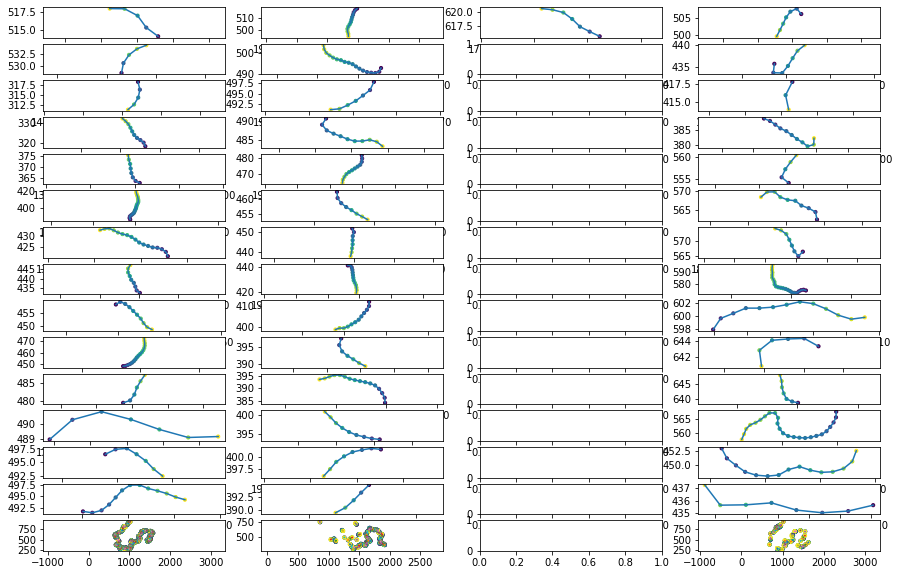

In [526]:
# Plot turns individually
nrTileRows = 15 # How many turns per cluster
i = np.zeros(len(dbClusts), dtype=int)
fig,axs = plt.subplots(nrTileRows,len(dbClusts), figsize=(15,10))
for tur in range(0,nrOfTurns):
    j = np.max(cRaw.turnDBCluster[cRaw.turn==tur]) # Which cluster the current turn is in
    axs[i[j],j].plot(cRaw.x[cRaw.turn==tur],cRaw.y[cRaw.turn==tur],)
    axs[i[j],j].scatter(cRaw.x[cRaw.turn==tur],cRaw.y[cRaw.turn==tur],c=cRaw.t[cRaw.turn==tur],s=10)
    axs[i[j],j].axis('equal')
    if i[j]<nrTileRows-1:
        i[j] += int(1)
    if np.all(i)>nrTileRows-1:
        break
        

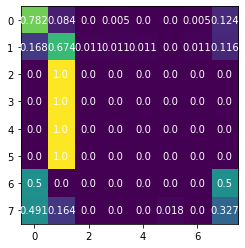

In [517]:
clustSeq = cRaw.groupby(['turn']).turnDBCluster.mean() # Which cluster is followed by which other cluster
transMat = np.array(transition_matrix(clustSeq.astype(int)))

# Plot transition matrix
fig, ax = plt.subplots()
im = ax.imshow(transMat)   
for i in range(len(transMat)):
    for j in range(len(transMat)):
        text = ax.text(j, i, round(transMat[i, j],3),
                       ha="center", va="center", color="w")
        

### DBSCAN on equal-length (arbitrary l)

In [27]:
# Create turn data matrix
turnLength = 10
#turnMat = np.reshape(cRaw.alpha[:len(cRaw)//turnLength*turnLength],(319,10))

turnMat = np.zeros((1,turnLength));  # Seed for appending curves
# [Insert for loop over IDs here]
turn = np.zeros((len(cRaw.alpha)-turnLength,turnLength)) # Preallocating
for t in range(0,len(cRaw.alpha)-turnLength): # Slide across track & make a turn at each t
    turn[t,:] = cRaw.alpha[t:t+turnLength]
turnMat = np.vstack((turnMat,turn))
# [ids here]
np.delete(turnMat,0,1) # Removes seed
turnMat.shape

(3184, 10)

In [622]:
# Cluster
epsilon = 333
dbCluster = DBSCAN(eps=epsilon, min_samples=5).fit(turnMat)
np.unique(dbCluster.labels_)

array([-1,  0], dtype=int64)

In [447]:
# DO ALL OF THE ABOVE AND MORE FOR RANDOM WALK CREATED FROM EDR TRACK

### #of Turns from k-means cluster distance & n-gram analysis
From Schwarz et al. 2015

In [ ]:
#import dtaidistance as dtaid NEEDS TO BE FIXED

# Make input list of turns
listOfTurns = []
for tur in np.unique(cRaw.turn):
    listOfTurns.append(np.asarray(cRaw.alphaAbs[cRaw.turn==tur]))
# Make DTW distance matrix (list of arrays)
ds = dtaid.dtw.distance_matrix_fast(listOfTurns)

model1 = clustering_hierarchical(dtaid.dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(listOfTurns)

model1 = clustering_hierarchical.Hierarchical(dtaid.dtw.distance_matrix_fast, {}, max_dist=80)
model2 = clustering_hierarchical.HierarchicalTree(model1)
cluster_idx = model2.fit(listOfTurns)
cluster_idx
model2.plot()

In [ ]:
#from sklearn.cluster import KMeans
# 1.: Find how many clusters are enough
kmFit = np.nan
kMax = 100
for k in range(1,kMax):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(turnMat)
    kmFit = -np.append(kmFit,kmeans.inertia_)


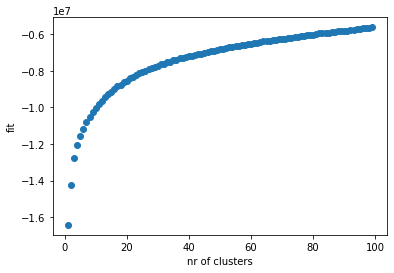

In [56]:
# Plot fit
plt.plot(kmFit,'o',c='k')
plt.xlabel('nr of turn clusters')
plt.ylabel('fit')
plt.show()

Text(0, 0.5, 'relative fit gain')

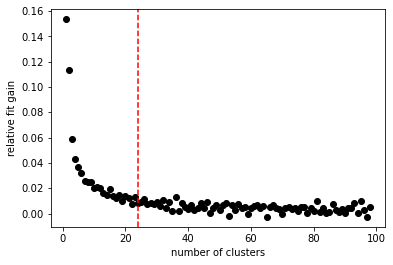

In [70]:
# Plot relative fit gain
fitGain = -np.divide(np.diff(kmFit),kmFit[1:])
plt.plot(fitGain,'o',c='k')
plt.axvline(x=24,ls='--',c='r')
plt.xlabel('number of turn clusters')
plt.ylabel('relative fit gain')
plt.show()

In [ ]:
# Where does the relative fit gain drop below 1%?
fitGainSm = lowess(fitGain, range(1,kMax), frac=5/kMax)
k = np.argwhere(fitGainSm[:,1]<0.01)[0]

dict_keys([22, 2, 7, 0, 10, 20, 9, 3, 12, 19, 11, 18, 4, 23, 21, 5, 15, 8, 14, 17, 6, 13, 16, 1])

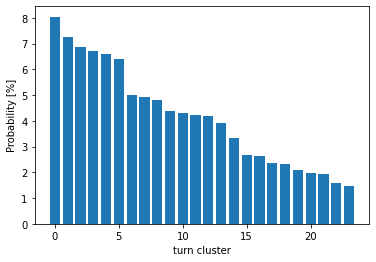

In [126]:
# 2. With the best #of clusters, find distribution of quantity of poses
#kmeans = KMeans(n_clusters=k, random_state=0).fit(turnMat)
clustNr = kmeans.labels_
from collections import Counter
clustNrCt = Counter(clustNr)
clustNrCt = dict(sorted(clustNrCt.items(), key=lambda item: item[1],reverse=True))
clustName = clustNrCt.keys()
clustFreq = np.divide(list(clustNrCt.values()),turnLength)
clustPerc = np.multiply(np.divide(clustFreq,sum(clustFreq)),100)
plt.bar(list(range(0,k)),clustPerc)
plt.xlabel('turn cluster')
plt.ylabel('Probability [%]')
#xTicks = str(list(clustName)) Doesn't work yet, make ticklabels be the cluster labels
#plt.xticks(np.arange(len(xTicks)),xTicks)
clustName

In [ ]:
# Plot cluster centers (=representatives cluster)
clustCtrs = np.radians(kmeans.cluster_centers_)

[x,y] = tf.alphaToTrack(clustCtrs[22,:])
plt.plot(x,y)
clustCtrs[22,:]

In [158]:
len(kmeans.labels_)

3184

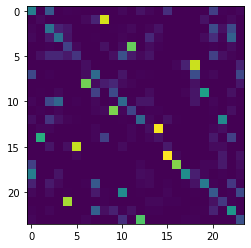

In [159]:
# 3. Get sequence of turns
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states
    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

clustList = clustNr

transMat = np.array(transition_matrix(clustList.astype(int)))

# Plot transition matrix
%matplotlib notebook
fig, ax = plt.subplots()
im = ax.imshow(transMat)   
#for i in range(len(transMat)):
    #for j in range(len(transMat)):
        #text = ax.text(j, i, round(transMat[i, j],3),
        #               ha="center", va="center", color="w")

In [448]:
# eigen?
# n-grams?
# others from that review paper? Ideally, talk to someone who know this sh*t